In [1]:
# Benchmarks corrections of deformations by calculating localization precision between cycles.

Processing clusters: 100%|██████████| 778/778 [00:00<00:00, 835.24it/s] 


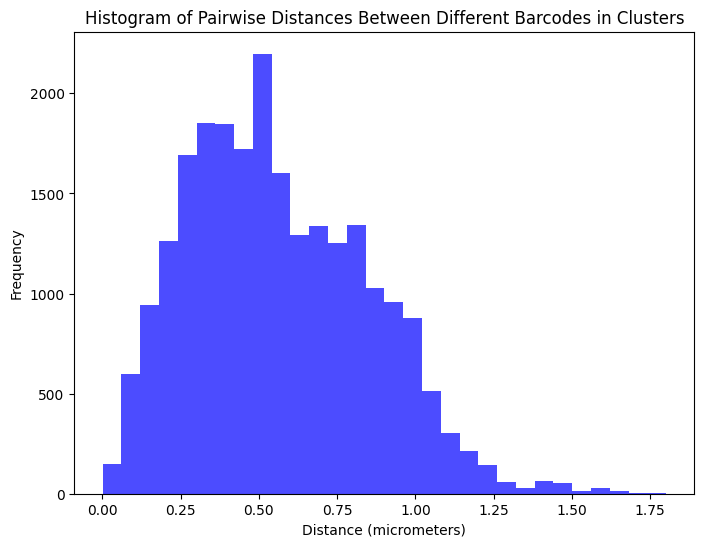

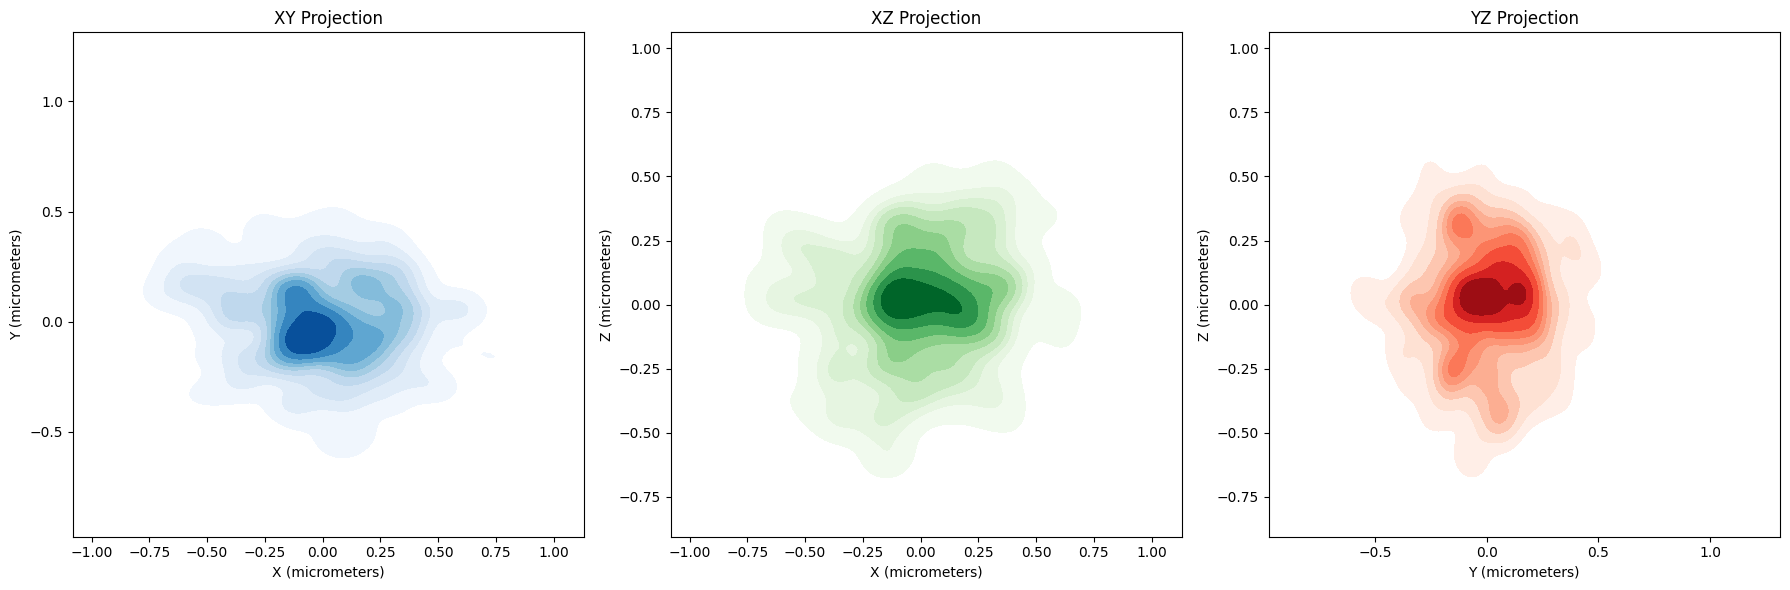

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from astropy.table import Table
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Function to read localizations from a file
def read_localizations(file_path):
    """Read a localizations table from a file."""
    return Table.read(file_path, format='ascii.ecsv')

# Function to compute the center of mass (centroid) for a set of points
def compute_center_of_mass(coordinates):
    """Compute the center of mass of a cluster."""
    return np.mean(coordinates, axis=0)

# Function to translate localizations to the center of mass of each cluster
def translate_to_center_of_mass(coordinates, center_of_mass):
    """Translate the points in a cluster so that the center of mass is at the origin."""
    return coordinates - center_of_mass

# Function to compute pairwise distances within a cluster
def compute_pairwise_distances(coordinates):
    """Compute pairwise distances between points in a cluster."""
    num_points = len(coordinates)
    distances = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distances.append(dist)
    return distances

# Function to plot the 2D kernel density estimate of XY, XZ, and YZ projections
def plot_translated_localizations(translated_coordinates_all_clusters):
    """Plot the 2D KDE density for XY, XZ, and YZ projections for all clusters."""
    all_xy = []
    all_xz = []
    all_yz = []

    # Collect all the translated coordinates for each projection (XY, XZ, YZ)
    for cluster_coords in translated_coordinates_all_clusters:
        cluster_coords = np.array(cluster_coords)
        all_xy.append(cluster_coords[:, :2])  # XY projection
        all_xz.append(cluster_coords[:, [0, 2]])  # XZ projection
        all_yz.append(cluster_coords[:, 1:])  # YZ projection
    
    all_xy = np.vstack(all_xy)
    all_xz = np.vstack(all_xz)
    all_yz = np.vstack(all_yz)

    # Create a figure with three subplots for XY, XZ, and YZ projections
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # XY projection
    sns.kdeplot(x=all_xy[:, 0], y=all_xy[:, 1], ax=axes[0], fill=True, cmap="Blues", thresh=0.05)
    axes[0].set_title('XY Projection')
    axes[0].set_xlabel('X (micrometers)')
    axes[0].set_ylabel('Y (micrometers)')

    # XZ projection
    sns.kdeplot(x=all_xz[:, 0], y=all_xz[:, 1], ax=axes[1], fill=True, cmap="Greens", thresh=0.05)
    axes[1].set_title('XZ Projection')
    axes[1].set_xlabel('X (micrometers)')
    axes[1].set_ylabel('Z (micrometers)')

    # YZ projection
    sns.kdeplot(x=all_yz[:, 0], y=all_yz[:, 1], ax=axes[2], fill=True, cmap="Reds", thresh=0.05)
    axes[2].set_title('YZ Projection')
    axes[2].set_xlabel('Y (micrometers)')
    axes[2].set_ylabel('Z (micrometers)')

    plt.tight_layout()
    plt.show()

# Main function to process the localizations, run clustering, and plot results
def process_localizations(file_path=None, localizations=None, distance_threshold=1.0):
    """
    Process localizations either from a file or from provided localizations data, 
    run KDTree clustering, and plot the results.
    """

    # If localizations are not provided, read from the file
    if localizations is None:
        if file_path is None:
            raise ValueError("Either file_path or localizations must be provided.")
        localizations = read_localizations(file_path)

    # Extract coordinates and barcode identities
    coordinates = []
    barcodes = []
    for row in tqdm(localizations, desc="Processing localizations"):
        barcode_number = int(row["Barcode #"])
        x = row['x']
        y = row['y']
        z = row['z']
        coordinates.append([x, y, z])
        barcodes.append(barcode_number)
    
    coordinates = np.array(coordinates)
    barcodes = np.array(barcodes)

    # Build KDTree and find clusters
    tree = KDTree(coordinates)
    clusters = tree.query_ball_tree(tree, distance_threshold)

    # Dictionary to hold pairwise distances for different barcodes within the same cluster
    pairwise_distances = []
    translated_coordinates_all_clusters = []

    # Iterate over the clusters to extract barcodes and calculate distances
    for cluster in tqdm(clusters, desc="Processing clusters"):
        if len(cluster) > 1:  # Only process clusters with more than one point
            cluster_barcodes = barcodes[cluster]
            cluster_coordinates = coordinates[cluster]
            
            # Compute the center of mass of the cluster
            center_of_mass = compute_center_of_mass(cluster_coordinates)
            
            # Translate all points to the center of mass
            translated_coordinates = translate_to_center_of_mass(cluster_coordinates, center_of_mass)
            translated_coordinates_all_clusters.append(translated_coordinates)
            
            # Check if there are different barcodes in the cluster
            if len(np.unique(cluster_barcodes)) > 1:
                distances = compute_pairwise_distances(cluster_coordinates)
                pairwise_distances.extend(distances)

    # Plot histogram of pairwise distances
    plt.figure(figsize=(8, 6))
    plt.hist(pairwise_distances, bins=30, color='blue', alpha=0.7)
    plt.xlabel('Distance (micrometers)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pairwise Distances Between Different Barcodes in Clusters')
    plt.show()

    # Visualize the translated localizations with 2D KDE projections
    plot_translated_localizations(translated_coordinates_all_clusters)

file_path = "/home/marcnol/data/blobel/tracing/data/Trace_3D_barcode_mask-mask0_ROI-1.ecsv"
process_localizations(file_path)


# plots scatterplot of localizations from cog

Processing clusters: 100%|██████████| 778/778 [00:00<00:00, 3044.65it/s]


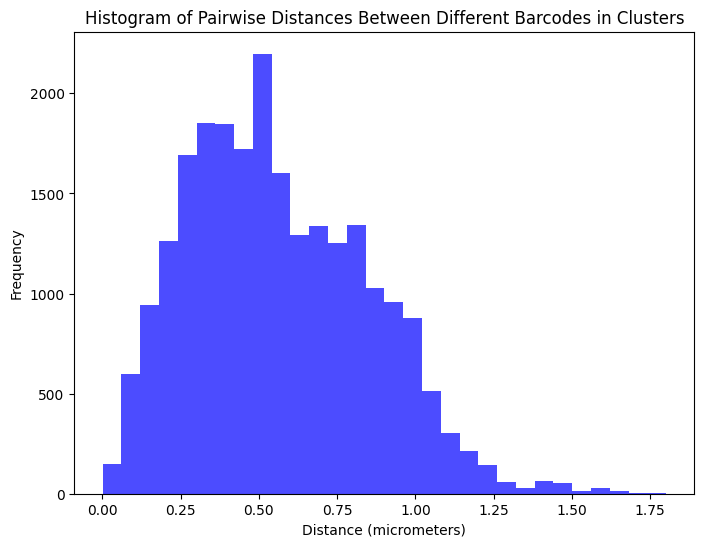

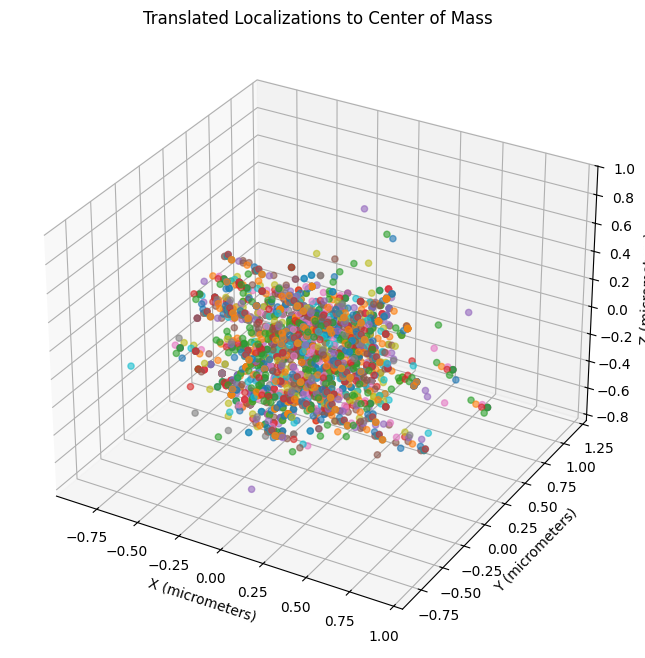

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from astropy.table import Table
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

# Function to read localizations from a file
def read_localizations(file_path):
    """Read a localizations table from a file."""
    return Table.read(file_path, format='ascii.ecsv')

# Function to compute the center of mass (centroid) for a set of points
def compute_center_of_mass(coordinates):
    """Compute the center of mass of a cluster."""
    return np.mean(coordinates, axis=0)

# Function to translate localizations to the center of mass of each cluster
def translate_to_center_of_mass(coordinates, center_of_mass):
    """Translate the points in a cluster so that the center of mass is at the origin."""
    return coordinates - center_of_mass

# Function to compute pairwise distances within a cluster
def compute_pairwise_distances(coordinates):
    """Compute pairwise distances between points in a cluster."""
    num_points = len(coordinates)
    distances = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distances.append(dist)
    return distances

# Function to plot the translated localizations for all clusters in 3D
def plot_translated_localizations(translated_coordinates_all_clusters):
    """Plot the translated localizations for all clusters in 3D."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster
    for cluster_coords in translated_coordinates_all_clusters:
        cluster_coords = np.array(cluster_coords)
        ax.scatter(cluster_coords[:, 0], cluster_coords[:, 1], cluster_coords[:, 2], s=20, alpha=0.6)

    ax.set_xlabel('X (micrometers)')
    ax.set_ylabel('Y (micrometers)')
    ax.set_zlabel('Z (micrometers)')
    ax.set_title('Translated Localizations to Center of Mass')
    plt.show()

# Main function to process the localizations, run clustering, and plot results
def process_localizations(file_path=None, localizations=None, distance_threshold=1.0):
    """
    Process localizations either from a file or from provided localizations data, 
    run KDTree clustering, and plot the results.
    """

    # If localizations are not provided, read from the file
    if localizations is None:
        if file_path is None:
            raise ValueError("Either file_path or localizations must be provided.")
        localizations = read_localizations(file_path)

    # Extract coordinates and barcode identities
    coordinates = []
    barcodes = []
    for row in tqdm(localizations, desc="Processing localizations"):
        barcode_number = int(row["Barcode #"])
        x = row['x']
        y = row['y']
        z = row['z']
        coordinates.append([x, y, z])
        barcodes.append(barcode_number)
    
    coordinates = np.array(coordinates)
    barcodes = np.array(barcodes)

    # Build KDTree and find clusters
    tree = KDTree(coordinates)
    clusters = tree.query_ball_tree(tree, distance_threshold)

    # Dictionary to hold pairwise distances for different barcodes within the same cluster
    pairwise_distances = []
    translated_coordinates_all_clusters = []

    # Iterate over the clusters to extract barcodes and calculate distances
    for cluster in tqdm(clusters, desc="Processing clusters"):
        if len(cluster) > 1:  # Only process clusters with more than one point
            cluster_barcodes = barcodes[cluster]
            cluster_coordinates = coordinates[cluster]
            
            # Compute the center of mass of the cluster
            center_of_mass = compute_center_of_mass(cluster_coordinates)
            
            # Translate all points to the center of mass
            translated_coordinates = translate_to_center_of_mass(cluster_coordinates, center_of_mass)
            translated_coordinates_all_clusters.append(translated_coordinates)
            
            # Check if there are different barcodes in the cluster
            if len(np.unique(cluster_barcodes)) > 1:
                distances = compute_pairwise_distances(cluster_coordinates)
                pairwise_distances.extend(distances)

    # Plot histogram of pairwise distances
    plt.figure(figsize=(8, 6))
    plt.hist(pairwise_distances, bins=30, color='blue', alpha=0.7)
    plt.xlabel('Distance (micrometers)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pairwise Distances Between Different Barcodes in Clusters')
    plt.show()

    # Visualize the translated localizations with a 3D scatter plot
    plot_translated_localizations(translated_coordinates_all_clusters)


file_path = "/home/marcnol/data/blobel/tracing/data/Trace_3D_barcode_mask-mask0_ROI-1.ecsv"
process_localizations(file_path)
